In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from functools import partial, reduce

### Dataframe Cleanup

In [2]:
df_metab = pd.read_csv('Metab_psych_data.csv')
df_bdi = pd.read_csv('Psychometric Data.csv')
df_card = pd.read_csv('CardioPanel_psych_data.csv')
df_cyto = pd.read_csv('Cytokines3_new_psych_data.csv')
df_lipid = pd.read_csv('Lipids_psych_data.csv')
df_metpan = pd.read_csv('MetabolicPanel_psych_data.csv')

In [3]:
def addSampleID (df, delID):
    df['Sample'] = df['id'].map(str) + '-' + df['Time'].map(str)
    first_col = df.pop("Sample")
    df.insert(0, "Sample", first_col)
    if delID == True:
        del df['Time']
        del df['bdi_total']
        del df['id']
    return df

In [4]:
for df in [df_metab, df_card, df_cyto, df_lipid, df_metpan]:
    df = addSampleID(df, True)
    df = df.groupby('Sample').mean().reset_index()
df_bdi = addSampleID(df_bdi, False)

In [5]:
df_bdi = df_bdi[['Sample', 'id', 'Time', 'bdi_total', 'depressed']]

In [6]:
df_demo = df_metab[['Sample', 'age', 'sex']]
del df_metab['age']
del df_metab['sex']
del df_metab['safe']

In [7]:
df_metab = df_metab.groupby('Sample').mean().reset_index()

In [8]:
del df_card['safe']
del df_card['plate']
df_card = df_card.groupby('Sample').mean().reset_index()
df_card = df_card.rename(columns = {"CHEX-1":"CHEX-1_1", "CHEX-2":"CHEX-2_1", "CHEX-3":"CHEX-3_1", "CHEX-4":"CHEX-4_1"})

In [9]:
del df_cyto['safe']
del df_cyto['Plate']
del df_cyto['Wells']
df_cyto = df_cyto.groupby('Sample').mean().reset_index()

In [10]:
del df_lipid['age']
del df_lipid['sex']
del df_lipid['safe']
df_lipid = df_lipid.groupby('Sample').mean().reset_index()

In [11]:
del df_metpan['safe']
del df_metpan['plate']
del df_metpan['Well']
df_metpan = df_metpan.groupby('Sample').mean().reset_index()
df_metpan = df_metpan.rename(columns = {"CHEX-1":"CHEX-1_2", "CHEX-2":"CHEX-2_2", "CHEX-3":"CHEX-3_2", "CHEX-4":"CHEX-4_2"})

### Fill Missing Data

In [12]:
pd.set_option('display.max_rows', 400)

In [13]:
m_s = df_metab['Sample'].unique()
l_s = df_lipid['Sample'].unique()
c_s = df_card['Sample'].unique()
y_s = df_cyto['Sample'].unique()
p_s = df_metpan['Sample'].unique()

In [14]:
union = reduce(np.union1d, (m_s, l_s, c_s, y_s, p_s))
df_bdi_reduced = df_bdi.loc[df_bdi['Sample'].isin(union)]

In [15]:
dfs = [df_bdi_reduced, df_demo, df_metab, df_card, df_cyto, df_lipid, df_metpan]
merge = partial(pd.merge, on=['Sample'], how='outer')
df = reduce(merge, dfs)

In [16]:
df = df[df['bdi_total'].notna()]

In [17]:
X = df.loc[:, ~df.columns.isin(['Sample', 'Time', 'depressed'])].values

In [18]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_imputed = imputer.fit_transform(X)

In [19]:
df_imputed = pd.DataFrame(X_imputed[:, 2:])
df_imputed.columns = np.array(df.columns)[5:]

In [20]:
df = pd.concat([df[['Sample', 'id', 'Time', 'bdi_total', 'depressed']].reset_index(), df_imputed], axis=1)
df = df.drop(columns='index')

### Train/Dev/Test Split

In [21]:
df_reduced = df[['id', 'depressed']].drop_duplicates()

In [22]:
np.random.seed(0)
all_index = np.array(df_reduced.index).flatten()
all_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 59, 97])

In [23]:
np.random.shuffle(all_index)
all_index

array([28, 33, 30,  4, 18, 11, 42, 31, 22, 10, 27, 32, 29, 43,  2, 59, 26,
       15, 25, 16, 40, 20, 41,  8, 13,  5, 17, 34, 14, 37,  7, 38,  1, 12,
       35, 24,  6, 23, 36, 21, 19,  9, 39, 97,  3,  0, 44])

In [24]:
test_index = all_index[:8]
dev_index = all_index[8:17]
train_index = all_index[17:]

In [25]:
test_id = df_reduced.reindex(test_index)['id'].to_numpy()
dev_id = df_reduced.reindex(dev_index)['id'].to_numpy()
train_id = df_reduced.reindex(train_index)['id'].to_numpy()

In [26]:
df_test = df.loc[df['id'].isin(test_id)]
df_dev = df.loc[df['id'].isin(dev_id)]
df_train = df.loc[df['id'].isin(train_id)]

In [27]:
df_test['Depressed at Time'] = df_test['bdi_total'] > 10
df_dev['Depressed at Time'] = df_dev['bdi_total'] > 10
df_train['Depressed at Time'] = df_train['bdi_total'] > 10

/home/joydoong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/joydoong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/joydoong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

### PCA

In [28]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [36]:
df_test_PCA = df_test[['Depressed at Time']].reset_index().drop(columns = 'index')
df_dev_PCA = df_dev[['Depressed at Time']].reset_index().drop(columns = 'index')
df_train_PCA = df_train[['Depressed at Time']].reset_index().drop(columns = 'index')

df_test_PCA_dict = {}
df_train_PCA_dict = {}
df_dev_PCA_dict = {}

for df_sub in [df_metab, df_card, df_cyto, df_lipid, df_metpan]:
    columns = df_sub.loc[:, df_sub.columns != 'Sample'].columns
    
    train_X = df_train[columns].values
    dev_X = df_dev[columns].values
    test_X = df_test[columns].values
    
    scaler = StandardScaler()
    scaler.fit(train_X)
    
    train_X = scaler.transform(train_X)
    dev_X = scaler.transform(dev_X)
    test_X = scaler.transform(test_X)
    
    pca = PCA(n_components = 5)
    fit = pca.fit(train_X)

    train_X = pca.transform(train_X)
    dev_X = pca.transform(dev_X)
    test_X = pca.transform(test_X)
    
    num_PCA = np.shape(train_X)[1]
    new_columns = [get_df_name(df_sub) + '_' + (item) for item in np.array(range(num_PCA)).astype(str)]
    
    
    df_test_t = pd.DataFrame(test_X, columns = new_columns)
    df_train_t = pd.DataFrame(train_X, columns = new_columns)
    df_dev_t = pd.DataFrame(dev_X, columns = new_columns)
    
    df_test_PCA_dict[get_df_name(df_sub)] = pd.concat([df_test[['Depressed at Time']].reset_index().drop(columns = 'index'), df_test_t], axis=1)
    df_train_PCA_dict[get_df_name(df_sub)] = pd.concat([df_train[['Depressed at Time']].reset_index().drop(columns = 'index'), df_train_t], axis=1)
    df_dev_PCA_dict[get_df_name(df_sub)] = pd.concat([df_dev[['Depressed at Time']].reset_index().drop(columns = 'index'), df_dev_t], axis=1)
    
    df_test_PCA = pd.concat([df_test_PCA, df_test_t], axis=1)
    df_train_PCA = pd.concat([df_train_PCA, df_train_t], axis=1)
    df_dev_PCA = pd.concat([df_dev_PCA, df_dev_t], axis=1)

df_card [ 46.76696875  70.77875445  84.83907454  94.09554966  96.77966679
  98.76141034  99.50311223  99.95210899  99.96771362  99.98188969
  99.99051348  99.99599943  99.99949521 100.        ]
df_cyto [ 64.96301588  79.51599153  89.26296522  93.97985122  97.84455648
  99.72892551  99.91350416  99.97407855  99.99505527  99.998169
  99.99952518  99.99991426 100.        ]
df_metpan [ 37.18792929  70.30215799  88.66036723  93.82075663  96.12207974
  97.82740489  99.35723429  99.73033734  99.87571071  99.95420534
  99.97457665  99.98880052  99.99398743  99.9967908   99.99899818
 100.        ]
df_lipid [ 78.80262767  90.65364861  92.59440763  94.25508128  95.41015345
  96.32024206  97.19377139  97.91276221  98.42088404  98.79594647
  99.0250803   99.2386273   99.3814619   99.49829911  99.58496087
  99.65743747  99.71709566  99.76186713  99.79484991  99.82481012
  99.84876523  99.87037726  99.88891831  99.9040147   99.91456929
  99.92354579  99.93130694  99.93890713  99.94500789  99.95045006

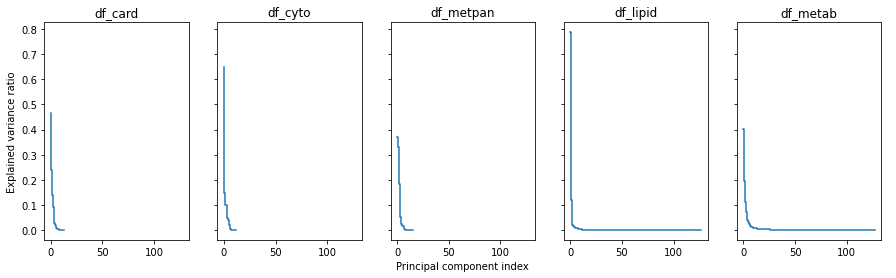

In [34]:
### Graph explained variance 
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(15,4))
fig.add_subplot(111, frameon=False)

index = 0
for df_sub in [df_card, df_cyto, df_metpan, df_lipid, df_metab]:
    columns = df_sub.loc[:, df_sub.columns != 'Sample'].columns
    
    train_X = df_train[columns].values

    pca = PCA(0.95)
    X_train_pca = pca.fit_transform(train_X)
    exp_var_pca = pca.explained_variance_ratio_
    print(get_df_name(df_sub), np.cumsum(exp_var_pca)*100)
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    axes[index].step(range(0,len(exp_var_pca)), exp_var_pca, where='mid', label= get_df_name(df_sub) + ' Explained variance')
    axes[index].set_title(get_df_name(df_sub))
    #plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    #plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    #axes[index].legend(loc='best')
    #axes.tight_layout()
    
    index += 1

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)    
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.show()

### Export

In [37]:
## Export
df_test_PCA.to_csv('test_set_PCA_mild.csv', index=False)
df_dev_PCA.to_csv('dev_set_PCA_mild.csv', index=False)
df_train_PCA.to_csv('train_set_PCA_mild.csv', index=False)

In [52]:
for thisdict in [df_test_PCA_dict, df_train_PCA_dict, df_dev_PCA_dict]:
    for key, df in thisdict.items():
        df.to_csv(get_df_name(thisdict) + '_' + key +'.csv', index=False)

### Other stuff

In [15]:
del df['Time']

In [17]:
del df_test['id']
del df_dev['id']
del df_train['id']
col_names = df_train.columns.values.tolist()

In [18]:
def quanTran (df):
    X = df.to_numpy()
    qt_X = quantile_transform(X[:, 1:], axis = 0, n_quantiles=20, output_distribution='normal', copy=True)
    set_qn = np.concatenate((X[:,:1], qt_X), axis=1)
    return set_qn

In [19]:
df_train = pd.DataFrame(quanTran(df_train))
df_dev = pd.DataFrame(quanTran(df_dev))
df_test = pd.DataFrame(quanTran(df_test))

/home/joydoong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (20) is greater than the total number of samples (19). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [20]:
df_train.columns = col_names
df_dev.columns = col_names
df_test.columns = col_names